In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/home/barbara/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open("names.txt", 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Vocabulary
chars = [c for c in '.abcdefghijklmnopqrstuvwxyz']

# Convertion between characters and integers
itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

In [4]:
vocab_size = len(chars)
block_size = 3
n_hidden = 256
n_emb = 10

In [5]:

def build_dataset(names):
    X, Y = [], []

    for name in names:
        c1 = [0] * block_size
        for ch in name + '.':
            X.append(c1)
            Y.append(stoi[ch])
            c1 = c1[1:] + [stoi[ch]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [6]:
g = torch.Generator().manual_seed(42)

In [7]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

Great video about normalizations: https://www.youtube.com/watch?v=sxEqtjLC0aM

In [8]:

class BatchNorm:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # True for training, False for evaluation

        # parameters
        self.gamma = torch.ones(dim)  # bn weight
        self.beta = torch.zeros(dim)  # bn bias

        # buffers (trained with a momentum update / not part of the backpropagation update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_hidden_act = (x - x_mean) / torch.sqrt(x_var + self.eps) 
        self.out = self.gamma * x_hidden_act + self.beta

        # update running buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
            


In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [10]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim, generator = g)
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out 

    def parameters(self):
        return [self.weight]
    

In [11]:
class Flatten:
    def __call__(self,x):
        self.out = x.view(x.size(0), -1)
        return self.out

    def parameters(self):
        return []

In [12]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:

model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb * block_size, n_hidden),  BatchNorm(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm(vocab_size)
])

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in model.layers:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

15711


In [14]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
max_steps = 200000
batch_size = 32
losses = []

for layer in model.layers:
    layer.training = True

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward passs
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    
    if(i % (max_steps//20) == 0):
        print(f"{i/max_steps*100:3.3}% complete - loss: {loss.item()}")
    losses.append(loss.log10().item())
    
    

0.0% complete - loss: 3.311657428741455
5.0% complete - loss: 2.346292018890381
10.0% complete - loss: 2.007478713989258
15.0% complete - loss: 2.3982999324798584
20.0% complete - loss: 2.2474448680877686
25.0% complete - loss: 2.0434794425964355
30.0% complete - loss: 1.954896092414856
35.0% complete - loss: 2.2078568935394287
40.0% complete - loss: 1.91230309009552
45.0% complete - loss: 2.2217752933502197
50.0% complete - loss: 2.0646772384643555
55.0% complete - loss: 2.327465295791626
60.0% complete - loss: 2.065821409225464
65.0% complete - loss: 2.2133302688598633
70.0% complete - loss: 2.122905731201172
75.0% complete - loss: 2.040889263153076
80.0% complete - loss: 2.188026189804077
85.0% complete - loss: 2.5992331504821777
90.0% complete - loss: 2.036402940750122
95.0% complete - loss: 2.0056843757629395


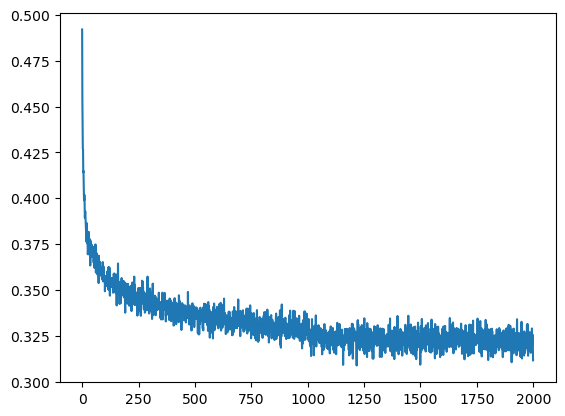

In [16]:
plt.plot(torch.tensor(losses).view(-1,100).mean(1))

## Evaluate the model

In [17]:
@torch.no_grad()
def split_loss(split):
    for layer in model.layers:
        layer.training = False
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0557291507720947
val 2.104560136795044


# Sample the model

In [18]:
num_samples = 20

for layer in model.layers:
    layer.training = False
    
for _ in range(num_samples):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join([itos[i] for i in out[:-1]]))

lousa
mere
ivirishannah
los
juliana
cael
brihadyn
adali
adde
holnen
ayanna
britan
ailah
branakies
cataleiya
ashawn
khan
kaysen
ken
andtaliz
